# 🤖 Phase 4: Predictive Modeling for Conversion

## Objective: Predicting Purchase Conversion for Signed-In Users

This notebook focuses on developing a machine learning model to predict user purchase conversion. Building on the insights from the Exploratory Data Analysis (EDA) and Funnel Analysis, a key bottleneck was identified in the "Signed In" to "Coupon Applied" and "Purchase Completed" stages.

The primary goal is to:

1.  **Define a Clear Prediction Target:** Identify what constitutes a "conversion" for modeling purposes.
2.  **Feature Engineering & Selection:** Prepare relevant features from the `events` data that could influence conversion.
3.  **Model Training:** Train a suitable classification model (e.g., Logistic Regression or RandomForest Classifier).
4.  **Model Evaluation:** Assess the model's performance using appropriate metrics (Precision, Recall, F1-Score, ROC-AUC).
5.  **Interpret Findings:** Understand which features are most impactful in predicting conversion, providing further actionable insights for product optimization.

This predictive capability can enable proactive interventions, such as targeted marketing or personalized in-app experiences, to improve user engagement and drive higher conversion rates.

# --- 1. Import Necessary Libraries ---

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import hashlib
import uuid
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

In [9]:
# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['figure.dpi'] = 100

# --- 2. Data Loading ---

In [14]:
# --- Load df_events directly from saved CSV ---
try:
    PROCESSED_EVENTS_CSV_PATH = r'../data/processed/events.csv'
    print("Proceeding to Data Preparation...")
except Exception as e:
    print(f"\nError saving df_events to CSV: {e}")

Proceeding to Data Preparation...


# --- 3. Data Preparation for Predictive Modeling ---  
--- Preparing data for the predictive model ---

In [15]:
# Define the target variable: 'purchase_completed' event indicates conversion.
# We need to determine for each session/user if a purchase event occurred.
# First, let's identify unique user-sessions that had a 'purchase_completed' event.
purchased_sessions = df_events[df_events['event_name'] == 'purchase_completed'][['user_id', 'session_id']].drop_duplicates()
purchased_sessions['is_purchased'] = 1

In [16]:
# Now, we define our modeling unit. We'll use sessions as the unit for prediction.
# For each session, we want to know if a purchase happened during that session.
# We'll aggregate events to session level to get the 'is_purchased' target for each session.

# Get a unique list of all sessions.
df_sessions_for_modeling = df_events[['user_id', 'session_id', 'event_timestamp', 'event_property_time_spent_seconds',
                                      'event_property_pages_visited', 'event_property_device_type',
                                      'event_property_traffic_source', 'user_demographic_age',
                                      'user_demographic_age_group', 'user_demographic_gender',
                                      'event_property_coupon_applied_flag', 'event_property_variant_group',
                                      'user_is_signed_in_session']].drop_duplicates(subset=['session_id'])

In [17]:
# Merge the purchase flag back to the session-level DataFrame
df_sessions_for_modeling = df_sessions_for_modeling.merge(purchased_sessions, on=['user_id', 'session_id'], how='left')
df_sessions_for_modeling['is_purchased'] = df_sessions_for_modeling['is_purchased'].fillna(0).astype(int)

In [18]:
# Filter for signed-in sessions only, as per project focus.
# This assumes 'user_is_signed_in_session' is True for signed-in sessions.
df_modeling_data = df_sessions_for_modeling[df_sessions_for_modeling['user_is_signed_in_session'] == True].copy()

In [19]:
# --- Feature Selection ---
# Identify features relevant for predicting conversion.
# Exclude identifiers, timestamps, and target variable itself.
# Include relevant user properties and session properties.

features = [
    'event_property_time_spent_seconds',
    'event_property_pages_visited',
    'event_property_device_type',
    'event_property_traffic_source',
    'user_demographic_age',
    'user_demographic_age_group',
    'user_demographic_gender',
    'event_property_coupon_applied_flag',
    'event_property_variant_group'
    # 'user_id', 'session_id', 'event_timestamp' are identifiers/timestamps
    # 'user_is_signed_in_session' is filtered to True, so not a feature
]

target = 'is_purchased'

In [20]:
X = df_modeling_data[features]
y = df_modeling_data[target]

print(f"Shape of features (X): {X.shape}")
print(f"Shape of target (y): {y.shape}")
print(f"Conversion rate in target: {y.mean():.2f}")

Shape of features (X): (20975, 9)
Shape of target (y): (20975,)
Conversion rate in target: 0.06


In [21]:
# --- Identify Numerical and Categorical Features ---
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()

print(f"\nNumerical features: {numerical_features}")
print(f"Categorical features: {categorical_features}")


Numerical features: ['event_property_time_spent_seconds', 'event_property_pages_visited', 'user_demographic_age']
Categorical features: ['event_property_device_type', 'event_property_traffic_source', 'user_demographic_age_group', 'user_demographic_gender', 'event_property_variant_group']


In [22]:
# --- Data Preprocessing Pipeline (Categorical Encoding and Numerical Scaling) ---
# Use ColumnTransformer for parallel processing of different column types.

# Preprocessor for numerical features (StandardScaler for normalization)
numerical_transformer = StandardScaler()

# Preprocessor for categorical features (OneHotEncoder for converting to numerical)
# handle_unknown='ignore' prevents errors if a new category appears in test set that wasn't in train
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Create a preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' # Keep columns not specified (e.g., already numerical and don't need scaling, or identifiers)
)

print("\nPreprocessor pipeline created successfully.")


Preprocessor pipeline created successfully.


In [23]:
# --- Split Data into Training and Testing Sets ---
# Stratify ensures that the proportion of target variable (is_purchased) is the same in train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTraining set shape (X_train, y_train): {X_train.shape}, {y_train.shape}")
print(f"Testing set shape (X_test, y_test): {X_test.shape}, {y_test.shape}")
print("\nData preparation complete. Ready for model training!")


Training set shape (X_train, y_train): (16780, 9), (16780,)
Testing set shape (X_test, y_test): (4195, 9), (4195,)

Data preparation complete. Ready for model training!


# --- 4. Model Selection and Training ---  
--- Selecting and Training the Predictive Model ---

In [ ]:
# --- Model 1: Random Forest Classifier ---
# A robust, tree-based ensemble model, good for classification and feature importance.
print("\nInitializing Random Forest Classifier...")
model_rf = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))]) # n_estimators: number of trees; class_weight='balanced' handles imbalance

print("Training Random Forest Classifier...")
model_rf.fit(X_train, y_train)
print("Random Forest Classifier training complete!")

print("\nModel training phase complete. Ready for evaluation!")


Initializing Random Forest Classifier...
Training Random Forest Classifier...
Random Forest Classifier training complete!

Model training phase complete. Ready for evaluation!


# --- 5. Model Evaluation ---  
--- Evaluating Model Performance ---

In [25]:
# Make predictions on the test set
y_pred_rf = model_rf.predict(X_test)
y_prob_rf = model_rf.predict_proba(X_test)[:, 1] # Probability of the positive class (1: purchased)

In [26]:
# --- Classification Report ---
print("\n--- Classification Report (Random Forest) ---")
print(classification_report(y_test, y_pred_rf, target_names=['No Purchase', 'Purchase']))


--- Classification Report (Random Forest) ---
              precision    recall  f1-score   support

 No Purchase       0.99      0.98      0.98      3962
    Purchase       0.71      0.82      0.76       233

    accuracy                           0.97      4195
   macro avg       0.85      0.90      0.87      4195
weighted avg       0.97      0.97      0.97      4195




--- Confusion Matrix (Random Forest) ---


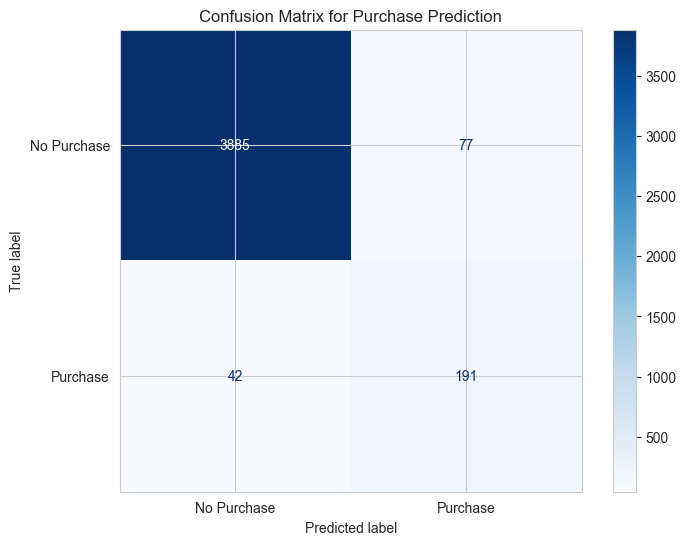

In [27]:
# --- Confusion Matrix ---
print("\n--- Confusion Matrix (Random Forest) ---")
fig, ax = plt.subplots(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Purchase', 'Purchase'])
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title('Confusion Matrix for Purchase Prediction')
plt.show()


--- ROC Curve and AUC Score (Random Forest) ---


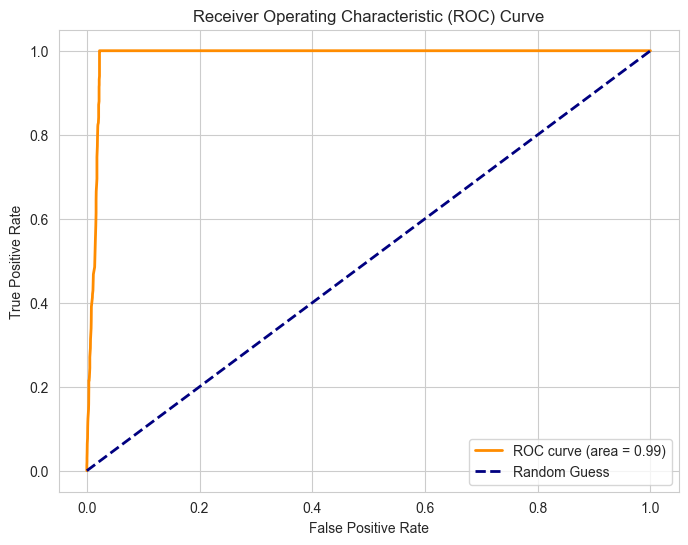


Random Forest AUC Score: 0.99

Model evaluation complete!


In [31]:
# --- ROC Curve and AUC Score ---
print("\n--- ROC Curve and AUC Score (Random Forest) ---")
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label=f'ROC curve (area = {auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print(f"\nRandom Forest AUC Score: {auc_rf:.2f}")
print("\nModel evaluation complete!")

# --- 6. Feature Importance ---  
--- Analyzing Feature Importance ---

In [35]:
# Access the trained classifier and preprocessor from the pipeline
classifier_rf = model_rf.named_steps['classifier']
preprocessor_rf = model_rf.named_steps['preprocessor']

# Get the feature names *after* preprocessing using get_feature_names_out()
# This is the correct and robust way to get all transformed feature names
try:
    feature_names_after_preprocessing = preprocessor_rf.get_feature_names_out()
except AttributeError:
    # Fallback for older scikit-learn versions or if get_feature_names_out is not available
    # This might still be prone to order issues but better than a full crash
    print("Warning: get_feature_names_out() not available. Attempting manual feature name extraction.")
    ohe_categories = preprocessor_rf.named_transformers_['cat'].categories_
    encoded_categorical_features_manual = [f'{col}_{cat}' for col, cats in zip(categorical_features, ohe_categories) for cat in cats]
    feature_names_after_preprocessing = numerical_features + encoded_categorical_features_manual

In [36]:
# Get feature importances from the Random Forest model
importances = classifier_rf.feature_importances_


Top 15 Feature Importances:
                                          feature  importance
0   remainder__event_property_coupon_applied_flag    0.878507
1          num__event_property_time_spent_seconds    0.035740
2                       num__user_demographic_age    0.029303
3               num__event_property_pages_visited    0.018512
4          cat__event_property_variant_group_Cold    0.003998
5      cat__event_property_traffic_source_Organic    0.002896
6          cat__event_property_device_type_Mobile    0.002778
7               cat__user_demographic_gender_Male    0.002689
8         cat__event_property_traffic_source_Paid    0.002668
9       cat__event_property_variant_group_Vibrant    0.002661
10      cat__event_property_traffic_source_Social    0.002534
11            cat__user_demographic_gender_Female    0.002488
12        cat__event_property_device_type_Desktop    0.002385
13    cat__event_property_traffic_source_Referral    0.002297
14         cat__event_property_device_typ

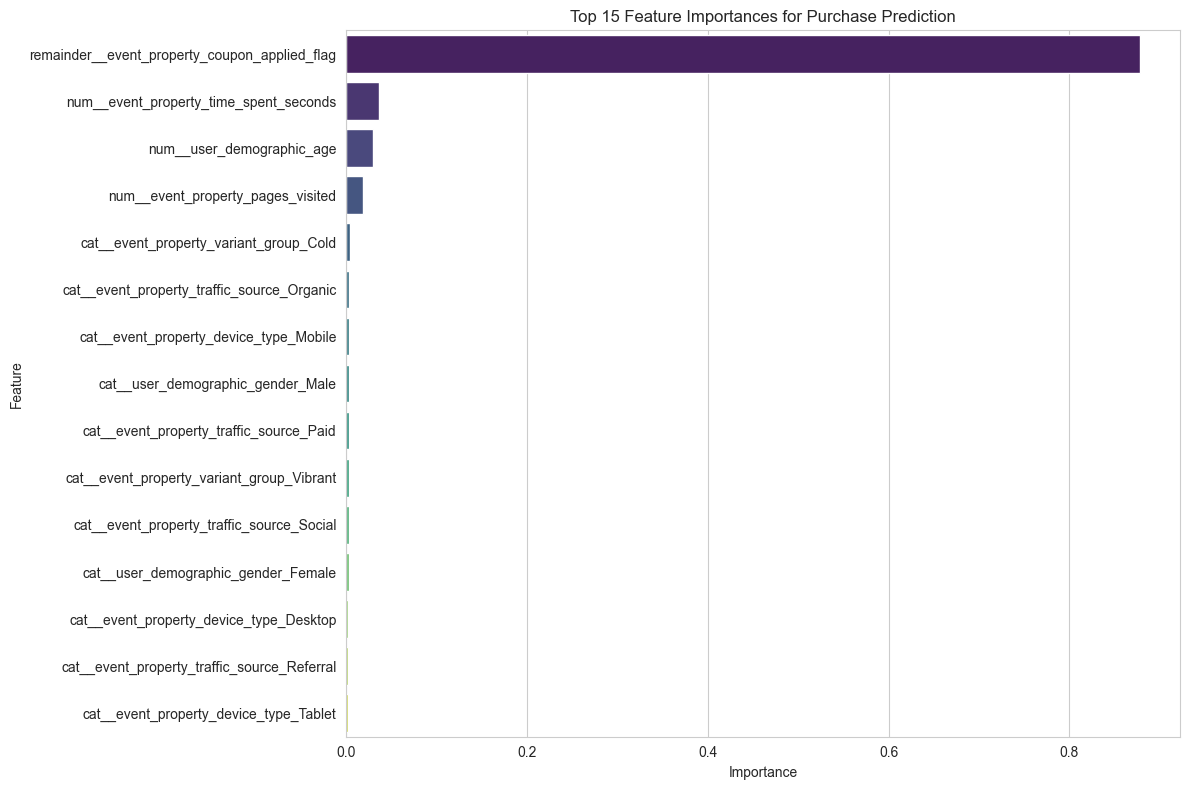


Feature importance analysis complete.


In [38]:
# Create a DataFrame for better visualization
if len(feature_names_after_preprocessing) == len(importances):
    feature_importances_df = pd.DataFrame({'feature': feature_names_after_preprocessing, 'importance': importances})
    feature_importances_df = feature_importances_df.sort_values('importance', ascending=False).reset_index(drop=True)

    print("\nTop 15 Feature Importances:")
    print(feature_importances_df.head(15))

    # Plotting Feature Importances
    plt.figure(figsize=(12, 8))
    sns.barplot(x='importance', y='feature', hue='feature', data=feature_importances_df.head(15), palette='viridis', legend=False)
    plt.title('Top 15 Feature Importances for Purchase Prediction')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()
else:
    print("\nError: Mismatch between extracted feature names and importance array length. Cannot plot feature importances reliably.")
    print(f"Number of extracted feature names: {len(feature_names_after_preprocessing)}")
    print(f"Number of feature importances: {len(importances)}")


print("\nFeature importance analysis complete.")